<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: Modelos Preditivos usando Redes Neurais Artificiais Séries Temporais da Bolsa de Valores<br>
<br>
ALUNA: Yuko Mitsuya</h3>

<p>Este notebook é um complemento do Trabalho de Conclusão de Curso. Pre-requisito para a obtenção do título de Especialista em Ciência de Dados e Big Data. </p>

## Imports

In [3]:

#Bibliotecas Básicas
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
import math

#Bibliotecas para carregamento dos dados
from pandas import read_json
from yahooquery import Ticker

#Bibliotecas para plotagem de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.graph_objs as go


#Bibliotecas para Preprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

#Bibliotecas para Modelagem
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

#Bibliotecas para Avaliação
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

## COLETA DADOS 

##### API de Yahoo! Finance

Utilizando API de Yahoo! Finance, será realizada a coleta de dados de alguns índices de mercado que afetam o preço das ações, neste trabalho são considerados do preço de fechamento ajustado ('adjclose') de: '^BVSP', '^DJI' e '^IXIC'.  Período analisado de 02/01/2007 a 31/12/2021.

'^BVSP' (Bovespa) - Segundo a B3, é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro, sendo referência para investidores ao redor do mundo.

'^DJI' (Dow Jones Industrial Average) - É o segundo mais antigo índice dos Estados Unidos. O cálculo deste índice é bastante simples e é baseado na cotação das ações de 30 das maiores e mais importantes empresas dos Estados Unidos (Wikipedia - Dow Jones Industrial Average).

'^IXIC' (Nasdaq) - É o segundo maior mercado de ações em capitalização do mundo. Caracteriza-se por reunir empresas de alta tecnologia em eletrônica, informática, telecomunicações, biotecnologia, e outras áreas similares e afins (Wikipedia - Nasdaq).


In [4]:
lista_indices = ['^BVSP', '^DJI', '^IXIC']
indices = pd.DataFrame()
for a in lista_indices:
    ticker = Ticker(a)
    i = ticker.history(start='2007-01-02', end='2021-12-31')['adjclose']
    indices[a] = i[a]
indices

^BVSP          ^DJI         ^IXIC
date                                            
2007-01-02   45383.0           NaN           NaN
2007-01-03   44445.0  12474.519531   2423.159912
2007-01-04   44020.0  12480.690430   2453.429932
2007-01-05   42245.0  12398.009766   2434.250000
2007-01-08   42830.0  12423.490234   2438.199951
...              ...           ...           ...
2021-12-23  104891.0  35950.558594  15653.370117
2021-12-27  105531.0  36302.378906  15871.259766
2021-12-28  104864.0  36398.210938  15781.719727
2021-12-29  104107.0  36488.628906  15766.219727
2021-12-30  104822.0  36398.078125  15741.559570

[3706 rows x 3 columns]

#### Taxa Selic e API do Portal Brasileiro de Dados Abertos do Banco Central

Coleta de dados da Taxa Selic % a.a utilizando a API do Banco Central período de 02/01/2007 a 31/12/2021. Os dados foram obtidos do Portal Brasileiro de Dados Abertos do Banco Central, que é o meio utilizado pelo Banco Central para disponibilizar dados e informações públicas.

Os mesmos dados, em formato csv, podem ser obtidos pelo link <http://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=csv&dataInicial=02/01/2007&dataFinal=31/12/2021>

Os dados são extraídos utilizando Pandas read_json()


In [5]:
link = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?dataInicial=02/01/2007&dataFinal=31/12/2021'
selic = pd.read_json(link)
selic

data  valor
0     02/01/2007  13.19
1     03/01/2007  13.18
2     04/01/2007  13.19
3     05/01/2007  13.19
4     08/01/2007  13.19
...          ...    ...
3763  27/12/2021   9.15
3764  28/12/2021   9.15
3765  29/12/2021   9.15
3766  30/12/2021   9.15
3767  31/12/2021   9.15

[3768 rows x 2 columns]

#### Cotação do Dólar e API do Portal Brasileiro de Dados Abertos do Banco Central

Coleta dados da cotação de compra e de venda do dólar utilizando a API do Banco Central período de 02/01/2007 a 31/12/2021.
Os mesmos dados, em formato csv, podem ser obtidos pelo link <https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial=%2701-02-2007%27&@dataFinalCotacao=%2712-31-2021%27&$format=text/csv&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao>

Os dados são extraídos utilizando Pandas read_json() também

In [6]:
dolar_j = pd.read_json(f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-02-2007'&@dataFinalCotacao='12-31-2021'&$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao")
dolar_j

@odata.context  \
0     https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
1     https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
2     https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
3     https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
4     https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
...                                                 ...   
3763  https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
3764  https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
3765  https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
3766  https://was-p.bcnet.bcb.gov.br/olinda/servico/...   
3767  https://was-p.bcnet.bcb.gov.br/olinda/servico/...   

                                                  value  
0     {'cotacaoCompra': 2.1334, 'cotacaoVenda': 2.13...  
1     {'cotacaoCompra': 2.1364, 'cotacaoVenda': 2.13...  
2     {'cotacaoCompra': 2.1421, 'cotacaoVenda': 2.14...  
3     {'cotacaoCompra': 2.1466, 'cotacaoVenda': 2.14...  
4     {'cotacaoCompra': 2.1497, 'cotacaoVenda': 2.15...  
...                                                 ...  
3763  {'cotacaoCompra': 5.6644000000000005, 'cotacao...  
3764  {'cotacaoCompra': 5.6432, 'cotacaoVenda': 5.64...  
3765  {'cotacaoCompra': 5.6613, 'cotacaoVenda': 5.66...  
3766  {'cotacaoCompra': 5.5799, 'cotacaoVenda': 5.58...  
3767  {'cotacaoCompra': 5.5799, 'cotacaoVenda': 5.58...  

[3768 rows x 2 columns]

In [7]:
dolar_j.value[0]

{'cotacaoCompra': 2.1334,
 'cotacaoVenda': 2.1342,
 'dataHoraCotacao': '2007-01-02 17:38:00.0'}

Como observado, os dados estão dispostos na coluna 'value' do Dataframe dolar_j, em um formato dict. Para facilitar a utilização dos dados, será criado um novo Dataframe chamado 'dolar' e armazenar os dados dos itens do dict 'value' ('dataHoraCotacao', 'cotacaoCompra' e 'cotacaoVenda') nas colunas 'data', 'dolar_Compra' e 'dolar_Venda', respectivamente nesta ordem.

In [9]:
#Organizando os dados
dolar = pd.DataFrame(columns=['data', 'dolar_Compra', 'dolar_Venda'])
for i, d in dolar_j.iterrows():
    data = dolar_j.value[i]['dataHoraCotacao']
    Compra = dolar_j.value[i]['cotacaoCompra']
    Venda = dolar_j.value[i]['cotacaoVenda']
    
    dolar.loc[i] = (data.split(' ')[0],  Compra,  Venda)

dolar

data  dolar_Compra  dolar_Venda
0     2007-01-02        2.1334       2.1342
1     2007-01-03        2.1364       2.1372
2     2007-01-04        2.1421       2.1429
3     2007-01-05        2.1466       2.1474
4     2007-01-08        2.1497       2.1505
...          ...           ...          ...
3763  2021-12-27        5.6644       5.6650
3764  2021-12-28        5.6432       5.6438
3765  2021-12-29        5.6613       5.6619
3766  2021-12-30        5.5799       5.5805
3767  2021-12-31        5.5799       5.5805

[3768 rows x 3 columns]

#### API de Yahoo! Finance e coleta de dados dos ativos alvos da pesquisa

Novamente, utilizando API do Yahoo! Finance, serão coletados os dados dos ativos a serem analisados passando como parâmetros:
o ticker do ativo (código do ativo negociado na B3), período de 02/01/2007 a 31/12/2021


In [10]:
#Coletando histórico da Companhia Siderúrgica Nacional (CSNA3) do setor Siderúrgico
csna3 = Ticker('CSNA3.SA').history(start = '2007-01-02', end = '2021-12-31')

#Coletando histórico de Banco do Brasil (BBAS3) do setor financeiro
bbas3 = Ticker('BBAS3.SA').history(start = '2007-01-02', end = '2021-12-31')

#Coletando histórico de TOTVs (TOTS3) do setor Tecnologia E Internet
tots3 = Ticker('TOTS3.SA').history(start = '2007-01-02', end = '2021-12-31')

#Coletando histórico de Brasil Foods S.A (BRFS3) do setor Consumo E Varejo
brfs3 = Ticker('BRFS3.SA').history(start = '2007-01-02', end = '2021-12-31')

In [11]:
csna3

volume       high       open      close        low  \
symbol   date                                                              
CSNA3.SA 2007-01-02  1521600  11.000000  10.800000  10.980000  10.791666   
         2007-01-03  3500400  10.943333  10.883333  10.628333  10.586666   
         2007-01-04  3291000  10.613333  10.613333  10.383333  10.341666   
         2007-01-05  4462200  10.476666  10.441666  10.083333  10.075000   
         2007-01-08  2899800  10.291666  10.258333  10.263333  10.110000   
...                      ...        ...        ...        ...        ...   
         2021-12-23  7220300  24.879999  24.770000  24.650000  24.420000   
         2021-12-27  5791500  24.980000  24.559999  24.920000  24.260000   
         2021-12-28  6394700  25.180000  24.889999  24.950001  24.549999   
         2021-12-29  6578800  25.170000  24.889999  25.040001  24.660000   
         2021-12-30  8263100  25.469999  25.209999  24.990000  24.900000   

                      adjclose  dividends  splits  
symbol   date                                      
CSNA3.SA 2007-01-02   5.724954        0.0     0.0  
         2007-01-03   5.541595        0.0     0.0  
         2007-01-04   5.413852        0.0     0.0  
         2007-01-05   5.257433        0.0     0.0  
         2007-01-08   5.351286        0.0     0.0  
...                        ...        ...     ...  
         2021-12-23  24.454447        0.0     0.0  
         2021-12-27  24.722305        0.0     0.0  
         2021-12-28  24.752068        0.0     0.0  
         2021-12-29  24.841354        0.0     0.0  
         2021-12-30  24.791750        0.0     0.0  

[3717 rows x 8 columns]

In [24]:
bbas3

close      volume       high        low       open  \
symbol   date                                                                 
BBAS3.SA 2007-01-02  21.910000   1956600.0  22.030001  21.173332  21.173332   
         2007-01-03  21.516666    822000.0  22.200001  21.516666  21.830000   
         2007-01-04  22.299999   1745100.0  22.299999  21.556665  21.666666   
         2007-01-05  21.333332   4962600.0  22.280001  21.003332  22.066666   
         2007-01-08  21.833332   2098200.0  21.933332  21.333332  21.403334   
...                        ...         ...        ...        ...        ...   
         2021-12-23  29.219999   7337800.0  29.480000  29.160000  29.299999   
         2021-12-27  29.280001   5746200.0  29.490000  29.200001  29.250000   
         2021-12-28  29.110001   8640700.0  29.389999  29.010000  29.340000   
         2021-12-29  28.959999   7666400.0  29.309999  28.940001  29.180000   
         2021-12-30  28.850000  12582800.0  29.190001  28.770000  29.129999   

                      adjclose  dividends  splits  
symbol   date                                      
BBAS3.SA 2007-01-02   9.686548        0.0     0.0  
         2007-01-03   9.512660        0.0     0.0  
         2007-01-04   9.858973        0.0     0.0  
         2007-01-05   9.431601        0.0     0.0  
         2007-01-08   9.652656        0.0     0.0  
...                        ...        ...     ...  
         2021-12-23  28.656694        0.0     0.0  
         2021-12-27  28.715538        0.0     0.0  
         2021-12-28  28.548815        0.0     0.0  
         2021-12-29  28.401705        0.0     0.0  
         2021-12-30  28.293829        0.0     0.0  

[3718 rows x 8 columns]

In [15]:
tots3

high       open   volume      close        low  \
symbol   date                                                              
TOTS3.SA 2007-01-02   3.140699   3.140699   931767   3.140699   3.074824   
         2007-01-03   3.327012   3.137372  1788391   3.260471   3.137372   
         2007-01-04   3.260471   3.260471  1731283   3.260471   3.226536   
         2007-01-05   3.260471   3.260471   259993   3.187277   3.160661   
         2007-01-08   3.260471   3.193931   486923   3.127391   3.060851   
...                        ...        ...      ...        ...        ...   
         2021-12-23  29.600000  29.600000  2731000  28.740000  28.330000   
         2021-12-27  29.500000  28.719999  3040900  28.809999  28.570000   
         2021-12-28  29.059999  28.629999  3269600  28.320000  28.260000   
         2021-12-29  28.629999  28.360001  3205000  27.889999  27.740000   
         2021-12-30  28.920000  28.020000  4400600  28.639999  27.580000   

                      adjclose  dividends  splits  
symbol   date                                      
TOTS3.SA 2007-01-02   2.386125       0.00     0.0  
         2007-01-03   2.477121       0.00     0.0  
         2007-01-04   2.477121       0.00     0.0  
         2007-01-05   2.421513       0.00     0.0  
         2007-01-08   2.376014       0.00     0.0  
...                        ...        ...     ...  
         2021-12-23  28.608072       0.00     0.0  
         2021-12-27  28.677750       0.00     0.0  
         2021-12-28  28.190001       0.00     0.0  
         2021-12-29  27.889999       0.13     0.0  
         2021-12-30  28.639999       0.00     0.0  

[3717 rows x 8 columns]

In [16]:
brfs3

open       high        low      close   volume  \
symbol   date                                                              
BRFS3.SA 2007-01-02  15.060000  15.225000  14.750000  14.995000   890800   
         2007-01-03  14.750000  15.090000  14.550000  14.595000  1258800   
         2007-01-04  14.600000  14.850000  14.300000  14.825000  1180600   
         2007-01-05  14.725000  15.000000  13.860000  14.150000  2161400   
         2007-01-08  14.250000  14.475000  13.955000  14.200000  1631600   
...                        ...        ...        ...        ...      ...   
         2021-12-23  22.209999  23.170000  22.150000  22.620001  9640400   
         2021-12-27  22.730000  23.160000  22.120001  22.230000  5729900   
         2021-12-28  22.230000  22.840000  22.070000  22.590000  3778300   
         2021-12-29  22.660000  22.750000  22.219999  22.360001  3108400   
         2021-12-30  22.620001  22.790001  22.219999  22.520000  4266500   

                      adjclose  dividends  splits  
symbol   date                                      
BRFS3.SA 2007-01-02  13.395100        0.0     0.0  
         2007-01-03  13.037778        0.0     0.0  
         2007-01-04  13.243237        0.0     0.0  
         2007-01-05  12.640256        0.0     0.0  
         2007-01-08  12.684922        0.0     0.0  
...                        ...        ...     ...  
         2021-12-23  22.620001        0.0     0.0  
         2021-12-27  22.230000        0.0     0.0  
         2021-12-28  22.590000        0.0     0.0  
         2021-12-29  22.360001        0.0     0.0  
         2021-12-30  22.520000        0.0     0.0  

[3717 rows x 8 columns]

## PROCESSAMENTO E TRATAMENTO DOS DADOS

Primeiramente, será necessário unir os dados de índice de mercado, Selic e Dólar em um único dataset. Para realizar a mesclagem dos dados, será utilizado o campo 'data', comum a todos os datasets. Antes disso, a coluna 'data', foi transformada em 'index' em todos os conjuntos de dados obtidos.

In [49]:
dolar.tail(5)

data  dolar_Compra  dolar_Venda
3763  2021-12-27        5.6644       5.6650
3764  2021-12-28        5.6432       5.6438
3765  2021-12-29        5.6613       5.6619
3766  2021-12-30        5.5799       5.5805
3767  2021-12-31        5.5799       5.5805

In [50]:
#Tornando todos index com o mesmo formato date
indices.index = pd.to_datetime(indices.index, format='%Y-%m-%d').date

#no caso do dataframe selic, precisa-se transformar a coluna 'data' em 'index' do dataframe
selic = selic.reset_index().set_index('data', drop=True) #substitui o 'index' pela 'data'
selic = selic.drop(columns=['index']) # exclui a colona index que não será necessária no estudo
selic.index = pd.to_datetime(selic.index, format='%d/%m/%Y').date

dolar = dolar.reset_index().set_index('data', drop=True) #substitui o 'index' pela 'data'
dolar = dolar.drop(columns=['index']) # exclui a colona 'index' que não será necessária no estudo
dolar.index = pd.to_datetime(dolar.index, format='%Y-%m-%d').date

In [51]:
dolar.tail(5)

dolar_Compra  dolar_Venda
2021-12-27        5.6644       5.6650
2021-12-28        5.6432       5.6438
2021-12-29        5.6613       5.6619
2021-12-30        5.5799       5.5805
2021-12-31        5.5799       5.5805

In [52]:
csna3.head(5)

volume       high       open      close        low  \
symbol   date                                                              
CSNA3.SA 2007-01-02  1521600  11.000000  10.800000  10.980000  10.791666   
         2007-01-03  3500400  10.943333  10.883333  10.628333  10.586666   
         2007-01-04  3291000  10.613333  10.613333  10.383333  10.341666   
         2007-01-05  4462200  10.476666  10.441666  10.083333  10.075000   
         2007-01-08  2899800  10.291666  10.258333  10.263333  10.110000   

                     adjclose  dividends  splits  
symbol   date                                     
CSNA3.SA 2007-01-02  5.724954        0.0     0.0  
         2007-01-03  5.541595        0.0     0.0  
         2007-01-04  5.413852        0.0     0.0  
         2007-01-05  5.257433        0.0     0.0  
         2007-01-08  5.351286        0.0     0.0

In [53]:
#Tornando a Data o indexador único no dataset de cada ativo.
#CSNA3
csna3 = csna3.reset_index().set_index('date', drop=True)
csna3 = csna3.drop(columns=['symbol'])

#BBAS3
bbas3 = bbas3.reset_index().set_index('date', drop=True)
bbas3 = bbas3.drop(columns=['symbol'])

#TOTS3
tots3 = tots3.reset_index().set_index('date', drop=True)
tots3 = tots3.drop(columns=['symbol'])

#BRFS3
brfs3 = brfs3.reset_index().set_index('date', drop=True)
brfs3 = brfs3.drop(columns=['symbol'])

In [54]:
csna3.head(5)

volume       high       open      close        low  adjclose  \
date                                                                        
2007-01-02  1521600  11.000000  10.800000  10.980000  10.791666  5.724954   
2007-01-03  3500400  10.943333  10.883333  10.628333  10.586666  5.541595   
2007-01-04  3291000  10.613333  10.613333  10.383333  10.341666  5.413852   
2007-01-05  4462200  10.476666  10.441666  10.083333  10.075000  5.257433   
2007-01-08  2899800  10.291666  10.258333  10.263333  10.110000  5.351286   

            dividends  splits  
date                           
2007-01-02        0.0     0.0  
2007-01-03        0.0     0.0  
2007-01-04        0.0     0.0  
2007-01-05        0.0     0.0  
2007-01-08        0.0     0.0

In [55]:
#Utilizando o método merge() os dados serão mesclados na seguinte ordem: 'indices', 'selic', 'dolar'. 
#Neste caso, somente os registros onde as 'datas' forem iguais, serão incluídos no novo dataset.
df_indices = indices.merge(selic, how='inner', left_index=True, right_index=True)
df_indices = df_indices.merge(dolar, how='inner', left_index=True, right_index=True)
df_indices.head(5)

^BVSP          ^DJI        ^IXIC  valor  dolar_Compra  \
2007-01-02  45383.0           NaN          NaN  13.19        2.1334   
2007-01-03  44445.0  12474.519531  2423.159912  13.18        2.1364   
2007-01-04  44020.0  12480.690430  2453.429932  13.19        2.1421   
2007-01-05  42245.0  12398.009766  2434.250000  13.19        2.1466   
2007-01-08  42830.0  12423.490234  2438.199951  13.19        2.1497   

            dolar_Venda  
2007-01-02       2.1342  
2007-01-03       2.1372  
2007-01-04       2.1429  
2007-01-05       2.1474  
2007-01-08       2.1505

In [56]:
#renomeia as colunas dos índices para melhor identificação
df_indices.rename(columns={'^BVSP': 'Bovespa',
                        '^DJI': 'Dow Jones',
                        '^IXIC': 'Nasdaq',
                        'valor': 'Selic'}, inplace=True)
df_indices.head(5)

Bovespa     Dow Jones       Nasdaq  Selic  dolar_Compra  \
2007-01-02  45383.0           NaN          NaN  13.19        2.1334   
2007-01-03  44445.0  12474.519531  2423.159912  13.18        2.1364   
2007-01-04  44020.0  12480.690430  2453.429932  13.19        2.1421   
2007-01-05  42245.0  12398.009766  2434.250000  13.19        2.1466   
2007-01-08  42830.0  12423.490234  2438.199951  13.19        2.1497   

            dolar_Venda  
2007-01-02       2.1342  
2007-01-03       2.1372  
2007-01-04       2.1429  
2007-01-05       2.1474  
2007-01-08       2.1505

In [57]:
csna3.iloc[-1]

volume       8.263100e+06
high         2.547000e+01
open         2.521000e+01
close        2.499000e+01
low          2.490000e+01
adjclose     2.479175e+01
dividends    0.000000e+00
splits       0.000000e+00
Name: 2021-12-30, dtype: float64

In [58]:
bbas3.iloc[-1]

close        2.885000e+01
volume       1.258280e+07
high         2.919000e+01
low          2.877000e+01
open         2.913000e+01
adjclose     2.829383e+01
dividends    0.000000e+00
splits       0.000000e+00
Name: 2021-12-30, dtype: float64

In [59]:
tots3.iloc[-1]

high         2.892000e+01
open         2.802000e+01
volume       4.400600e+06
close        2.864000e+01
low          2.758000e+01
adjclose     2.864000e+01
dividends    0.000000e+00
splits       0.000000e+00
Name: 2021-12-30, dtype: float64

In [60]:
brfs3.iloc[-1]

open         2.262000e+01
high         2.279000e+01
low          2.222000e+01
close        2.252000e+01
volume       4.266500e+06
adjclose     2.252000e+01
dividends    0.000000e+00
splits       0.000000e+00
Name: 2021-12-30, dtype: float64

Nesta etapa mescla-se os dados dataset recem-criado com os dados de cada ativo

In [61]:
#Preparando os datasets para o estudo
def prepara_dados(ativo, indices):
    #Mescla df_indices com os dados do ativo
    df = indices.merge(ativo, how='inner', left_index=True, right_index=True)
    
    #agregando novos dados: média móvel dos 7 dias e média móvel dos 21 dias
    #cria uma coluna com a média móvel de 7 dias
    df['mdmv7'] = df.close.rolling(7).mean()
    #cria uma coluna com a média móvel de 21 dias
    df['mdmv21'] = df.close.rolling(21).mean()
    #substitui o valor de fechamento do dia atual para o valor do dia seguinte
    df['alvo'] = df.close.shift(-1)
    
    print(f'Valores Faltantes: \n{df.isnull().sum()}\n') #Verifica dados faltantes
    df = df.dropna() #elimina valores NaN que podem prejudicar nosso modelo
    
    #reorganizando as colunas e permanecem somente as colunas que estão na lista 'colunas'
    colunas = ['Bovespa', 'Dow Jones', 'Nasdaq', 'Selic', 'dolar_Compra', 'dolar_Venda', 'high', 
               'low', 'open', 'volume', 'close', 'adjclose', 'alvo', 'mdmv7', 'mdmv21']
    df = df[colunas]
    
    return(df)

In [62]:
#Preparando dados para CSNA3
df_csna3 = prepara_dados(csna3, df_indices)

#Preparando dados para BBAS3
df_bbas3 = prepara_dados(bbas3, df_indices)

#Preparando dados para TOTS3
df_tots3 = prepara_dados(tots3, df_indices)

#Preparando dados para TOTS3
df_brfs3 = prepara_dados(brfs3, df_indices)

Valores Faltantes: 
Bovespa          0
Dow Jones       89
Nasdaq          89
Selic            0
dolar_Compra     0
dolar_Venda      0
volume           0
high             0
open             0
close            0
low              0
adjclose         0
dividends        0
splits           0
mdmv7            6
mdmv21          20
alvo             1
dtype: int64

Valores Faltantes: 
Bovespa          0
Dow Jones       89
Nasdaq          89
Selic            0
dolar_Compra     0
dolar_Venda      0
close            0
volume           0
high             0
low              0
open             0
adjclose         0
dividends        0
splits           0
mdmv7            6
mdmv21          20
alvo             1
dtype: int64

Valores Faltantes: 
Bovespa          0
Dow Jones       89
Nasdaq          89
Selic            0
dolar_Compra     0
dolar_Venda      0
high             0
open             0
volume           0
close            0
low              0
adjclose         0
dividends        0
splits           0


In [63]:
df_csna3.isnull().sum()

Bovespa         0
Dow Jones       0
Nasdaq          0
Selic           0
dolar_Compra    0
dolar_Venda     0
high            0
low             0
open            0
volume          0
close           0
adjclose        0
alvo            0
mdmv7           0
mdmv21          0
dtype: int64

Caso necessário, armazenar os dados em formato csv para análise posterior, os dataset foram armazenados em um diretório chamado 'Projeto_tcc/' com o seguinte formato: 'base_{ticker}.csv', onde {ticker} é o nome do código do ativo negociado na B3 que foi coletado.

In [64]:
df_csna3.to_csv(f'Projeto_tcc/base_CSNA3.csv')
df_bbas3.to_csv(f'Projeto_tcc/base_BBAS3.csv')
df_tots3.to_csv(f'Projeto_tcc/base_TOTS3.csv')
df_brfs3.to_csv(f'Projeto_tcc/base_BRFS3.csv')

## ANÁLISE EXPLORATÓRIA DOS DADOS

### Comparando características dos datasets

Comparação quanto a Dimensão: Todos possuem a mesma quantidade de linhas e colunas (3598 linhas, 15 colunas)

In [65]:
df_csna3.shape

(3598, 15)

In [66]:
df_bbas3.shape

(3598, 15)

In [67]:
df_tots3.shape

(3598, 15)

In [68]:
df_brfs3.shape

(3598, 15)

In [69]:
df_csna3.describe()

Bovespa     Dow Jones        Nasdaq        Selic  dolar_Compra  \
count    3598.000000   3598.000000   3598.000000  3598.000000   3598.000000   
mean    68439.427460  18045.395407   5253.160933     9.356342      2.927009   
std     21684.898084   7158.716120   3434.832807     3.384942      1.210195   
min     29435.000000   6547.049805   1268.640015     1.900000      1.533700   
25%     53344.250000  12422.259766   2601.022522     6.900000      1.873400   
50%     61982.000000  16488.150391   4370.334961    10.150000      2.381350   
75%     76895.750000  24214.908203   7100.252441    11.920000      3.756675   
max    130776.000000  36488.628906  16057.440430    14.150000      5.936600   

       dolar_Venda         high          low         open        volume  \
count  3598.000000  3598.000000  3598.000000  3598.000000  3.598000e+03   
mean      2.927676    16.792676    16.152109    16.481020  7.636400e+06   
std       1.210139    10.024050     9.735006     9.894185  5.186796e+06   
min       1.534500     2.940000     2.740000     2.800000  0.000000e+00   
25%       1.874200     9.360000     8.950000     9.172500  4.286425e+06   
50%       2.382050    13.368333    12.850000    13.100000  6.268150e+06   
75%       3.757275    23.246250    22.317500    22.750000  9.758375e+06   
max       5.937200    53.900002    50.740002    52.209999  7.478640e+07   

             close     adjclose         alvo        mdmv7       mdmv21  
count  3598.000000  3598.000000  3598.000000  3598.000000  3598.000000  
mean     16.457875    11.583515    16.462695    16.447845    16.418219  
std       9.880029     7.967423     9.880469     9.857669     9.811919  
min       2.740000     2.165402     2.740000     3.038571     3.417619  
25%       9.122500     6.768922     9.130000     9.127143     9.130833  
50%      13.115000     8.803947    13.120000    13.025714    12.889048  
75%      22.799999    14.309889    22.799999    22.752321    22.648512  
max      51.770000    49.966270    51.770000    50.151429    49.370000

In [70]:
df_bbas3.describe()

Bovespa     Dow Jones        Nasdaq        Selic  dolar_Compra  \
count    3598.000000   3598.000000   3598.000000  3598.000000   3598.000000   
mean    68439.427460  18045.395407   5253.160933     9.356342      2.927009   
std     21684.898084   7158.716120   3434.832807     3.384942      1.210195   
min     29435.000000   6547.049805   1268.640015     1.900000      1.533700   
25%     53344.250000  12422.259766   2601.022522     6.900000      1.873400   
50%     61982.000000  16488.150391   4370.334961    10.150000      2.381350   
75%     76895.750000  24214.908203   7100.252441    11.920000      3.756675   
max    130776.000000  36488.628906  16057.440430    14.150000      5.936600   

       dolar_Venda         high          low         open        volume  \
count  3598.000000  3598.000000  3598.000000  3598.000000  3.598000e+03   
mean      2.927676    29.069460    28.162118    28.627277  8.479563e+06   
std       1.210139     8.406879     8.262678     8.347807  7.867395e+06   
min       1.534500    12.500000    11.020000    12.150000  0.000000e+00   
25%       1.874200    23.735000    23.001667    23.402500  4.180700e+06   
50%       2.382050    28.290001    27.405000    27.850000  6.738900e+06   
75%       3.757275    31.860001    30.887499    31.382500  1.066472e+07   
max       5.937200    55.910000    54.820000    55.599998  2.272360e+08   

             close     adjclose         alvo        mdmv7       mdmv21  
count  3598.000000  3598.000000  3598.000000  3598.000000  3598.000000  
mean     28.609570    19.338425    28.610016    28.607231    28.588156  
std       8.337428     9.651431     8.335398     8.305628     8.238301  
min      11.410000     5.044436    11.410000    12.831429    13.187619  
25%      23.342500    12.700360    23.350000    23.366429    23.323095  
50%      27.850000    14.954458    27.845000    27.844286    27.810952  
75%      31.397500    25.963285    31.400000    31.356785    31.292857  
max      55.000000    47.077305    55.180000    54.394285    53.251904

In [71]:
df_tots3.describe()

Bovespa     Dow Jones        Nasdaq        Selic  dolar_Compra  \
count    3598.000000   3598.000000   3598.000000  3598.000000   3598.000000   
mean    68439.427460  18045.395407   5253.160933     9.356342      2.927009   
std     21684.898084   7158.716120   3434.832807     3.384942      1.210195   
min     29435.000000   6547.049805   1268.640015     1.900000      1.533700   
25%     53344.250000  12422.259766   2601.022522     6.900000      1.873400   
50%     61982.000000  16488.150391   4370.334961    10.150000      2.381350   
75%     76895.750000  24214.908203   7100.252441    11.920000      3.756675   
max    130776.000000  36488.628906  16057.440430    14.150000      5.936600   

       dolar_Venda         high          low         open        volume  \
count  3598.000000  3598.000000  3598.000000  3598.000000  3.598000e+03   
mean      2.927676    12.376362    11.960833    12.172386  2.238461e+06   
std       1.210139     7.880455     7.586735     7.741255  3.328526e+06   
min       1.534500     2.328908     2.229098     2.263698  0.000000e+00   
25%       1.874200     8.593672     8.298399     8.474731  8.211565e+05   
50%       2.382050    10.747911    10.401903    10.579898  1.444539e+06   
75%       3.757275    13.160827    12.775726    12.978673  2.742951e+06   
max       5.937200    41.240002    39.570000    40.529999  1.099904e+08   

             close     adjclose         alvo        mdmv7       mdmv21  
count  3598.000000  3598.000000  3598.000000  3598.000000  3598.000000  
mean     12.173326    11.207758    12.180551    12.154726    12.103847  
std       7.739573     7.937153     7.745518     7.723728     7.681133  
min       2.262368     1.755617     2.262368     2.339840     2.445037  
25%       8.431480     7.329985     8.436471     8.464988     8.464829  
50%      10.563263     9.586174    10.566590    10.546057    10.509634  
75%      12.975346    11.443209    12.978673    12.946591    12.885834  
max      40.599998    40.413628    40.599998    39.569999    38.714762

In [72]:
df_brfs3.describe()

Bovespa     Dow Jones        Nasdaq        Selic  dolar_Compra  \
count    3598.000000   3598.000000   3598.000000  3598.000000   3598.000000   
mean    68439.427460  18045.395407   5253.160933     9.356342      2.927009   
std     21684.898084   7158.716120   3434.832807     3.384942      1.210195   
min     29435.000000   6547.049805   1268.640015     1.900000      1.533700   
25%     53344.250000  12422.259766   2601.022522     6.900000      1.873400   
50%     61982.000000  16488.150391   4370.334961    10.150000      2.381350   
75%     76895.750000  24214.908203   7100.252441    11.920000      3.756675   
max    130776.000000  36488.628906  16057.440430    14.150000      5.936600   

       dolar_Venda         high          low         open        volume  \
count  3598.000000  3598.000000  3598.000000  3598.000000  3.598000e+03   
mean      2.927676    34.359173    33.361304    33.872321  3.936506e+06   
std       1.210139    14.931503    14.704033    14.814952  6.282340e+06   
min       1.534500    12.695000    11.520000    12.065000  0.000000e+00   
25%       1.874200    22.322500    21.512500    21.950001  1.674475e+06   
50%       2.382050    29.585000    28.724999    29.175000  2.485700e+06   
75%       3.757275    45.647501    44.487501    45.052500  4.487475e+06   
max       5.937200    72.470001    71.589996    72.239998  2.146761e+08   

             close     adjclose         alvo        mdmv7       mdmv21  
count  3598.000000  3598.000000  3598.000000  3598.000000  3598.000000  
mean     33.868182    32.479053    33.871723    33.863526    33.846974  
std      14.830646    14.678481    14.830244    14.819804    14.791381  
min      12.255000    10.947445    12.255000    12.586429    13.067857  
25%      21.930000    20.700001    21.941250    21.940000    21.805595  
50%      29.100000    27.466603    29.100000    29.095714    28.947857  
75%      45.122500    43.894249    45.122500    45.083571    45.070476  
max      72.070000    70.204323    72.070000    71.555714    70.263809

### Distribuição de preços por empresa 

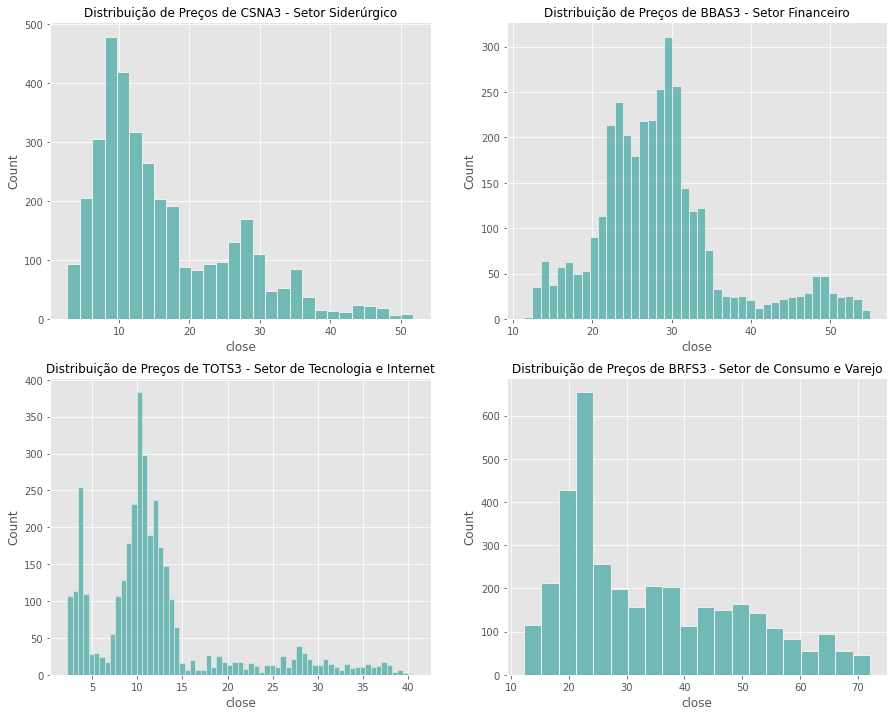

In [73]:
plt.style.use("ggplot")
figs, axs = plt.subplots(2, 2, figsize=(15, 12)) 

sns.set_context('notebook', font_scale= 1.0, rc={'font.size':10, 'axes.titlesize':12, 'axes.labelsize':10})

ax = sns.histplot(df_csna3.close, color= '#4baba4', ax = axs[0][0])
ax.set(title = f'Distribuição de Preços de CSNA3 - Setor Siderúrgico')

ax = sns.histplot(df_bbas3.close, color= '#4baba4', ax = axs[0][1])
ax.set(title = f'Distribuição de Preços de BBAS3 - Setor Financeiro')

ax = sns.histplot(df_tots3.close, color= '#4baba4', ax = axs[1][0])
ax.set(title = f'Distribuição de Preços de TOTS3 - Setor de Tecnologia e Internet')

ax = sns.histplot(df_brfs3.close, color= '#4baba4', ax = axs[1][1])
ax.set(title = f'Distribuição de Preços de BRFS3 - Setor de Consumo e Varejo')


plt.show()

### Histórico de Preço de Fechamento das ações no período analisado

In [74]:
csna = {
    'x': df_csna3.index,
    'y': df_csna3.close,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'blue'
    },
    'name': 'CSNA3',
    'showlegend': True
}

bbas = {
    'x' : df_bbas3.index,
    'y' : df_bbas3.close,
    'type': 'scatter',
    'mode' : 'lines',
    'line' : {
        'width': 1,
        'color': 'red'},
    'name' : 'BBAS3',
    'showlegend' : True
}

tots = {
    'x' : df_tots3.index,
    'y' : df_tots3.close,
    'type': 'scatter',
    'mode' : 'lines',
    'line' : {
        'width': 1,
        'color': 'purple'},
    'name' : 'TOTS3',
    'showlegend' : True
}

brfs = {
    'x' : df_brfs3.index,
    'y' : df_brfs3.close,
    'type': 'scatter',
    'mode' : 'lines',
    'line' : {
        'width': 1,
        'color': 'green'},
    'name' : 'BRFS3',
    'showlegend' : True
}


data = [csna, bbas, tots, brfs]

layout = {
'title': 'Histórico de preços de fechamento das ações analisadas no período de 01/2007 a 12/2021',
'title_x': 0.5,
'yaxis': {'title': ' Cotação '}
}


fig = dict(data=data, layout=layout)

py.iplot(fig)

### Variação de preço diário por empresa

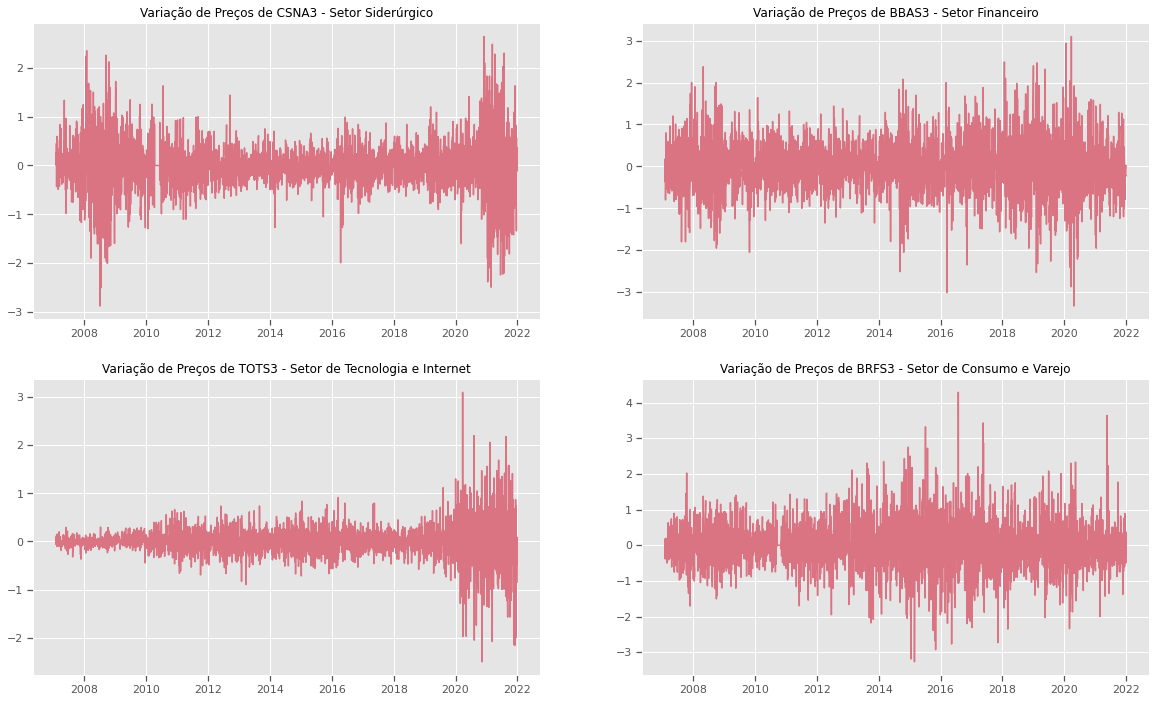

In [75]:
plt.style.use("ggplot")
figs, axs = plt.subplots(2, 2, figsize=(20, 12)) 

sns.set_context('notebook', font_scale= 1.0, rc={'font.size':12, 'axes.titlesize':12, 'axes.labelsize':12})

ax = sns.lineplot(x = df_csna3.index, y = (df_csna3.close - df_csna3.open) , color= '#da7483', ax = axs[0][0])
ax.set(title = f'Variação de Preços de CSNA3 - Setor Siderúrgico')

ax = sns.lineplot(x = df_bbas3.index, y = (df_bbas3.close - df_bbas3.open), color= '#da7483', ax = axs[0][1])
ax.set(title = f'Variação de Preços de BBAS3 - Setor Financeiro')

ax = sns.lineplot(x = df_tots3.index, y = (df_tots3.close - df_tots3.open), color= '#da7483', ax = axs[1][0])
ax.set(title = f'Variação de Preços de TOTS3 - Setor de Tecnologia e Internet')

ax = sns.lineplot(x = df_brfs3.index, y = (df_brfs3.close - df_brfs3.open), color= '#da7483', ax = axs[1][1])
ax.set(title = f'Variação de Preços de BRFS3 - Setor de Consumo e Varejo')


plt.show()

### Volume de negociação

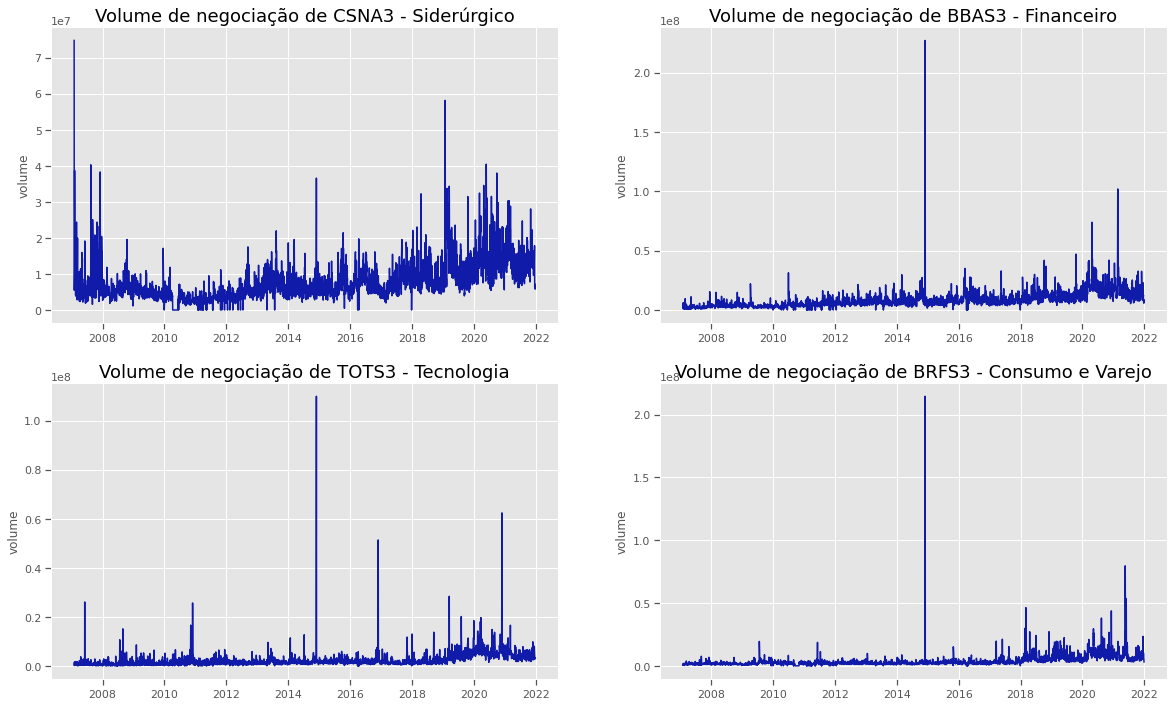

In [76]:
plt.style.use("ggplot")
figs, axs = plt.subplots(2, 2, figsize=(20, 12)) 

sns.set_context('notebook', font_scale= 1.0, rc={'font.size':16, 'axes.titlesize':18, 'axes.labelsize':16})

ax = sns.lineplot(x = df_csna3.index, y = df_csna3.volume , color= '#111ba9', ax = axs[0][0])
ax.set(title = f'Volume de negociação de CSNA3 - Siderúrgico')

ax = sns.lineplot(x = df_bbas3.index, y = df_bbas3.volume, color= '#111ba9', ax = axs[0][1])
ax.set(title = f'Volume de negociação de BBAS3 - Financeiro')

ax = sns.lineplot(x = df_tots3.index, y = df_tots3.volume, color= '#111ba9', ax = axs[1][0])
ax.set(title = f'Volume de negociação de TOTS3 - Tecnologia')

ax = sns.lineplot(x = df_brfs3.index, y = df_brfs3.volume, color= '#111ba9', ax = axs[1][1])
ax.set(title = f'Volume de negociação de BRFS3 - Consumo e Varejo')

plt.show()

Encontrando a data onde o volume de negociação foi maior.

In [77]:
#Data e volume de negociação para CSNA3
{'Data': df_csna3.index[df_csna3.volume.argmax()], 'Volume': df_csna3.volume[df_csna3.volume.argmax()]}

{'Data': datetime.date(2007, 1, 31), 'Volume': 74786400}

In [78]:
#Data e volume de negociação para BBAS3
{'Data': df_bbas3.index[df_bbas3.volume.argmax()], 'Volume': df_bbas3.volume[df_bbas3.volume.argmax()]}

{'Data': datetime.date(2014, 12, 1), 'Volume': 227236007.0}

In [79]:
#Data e volume de negociação para TOTS3
{'Data': df_tots3.index[df_tots3.volume.argmax()], 'Volume': df_tots3.volume[df_tots3.volume.argmax()]}

{'Data': datetime.date(2014, 12, 1), 'Volume': 109990357}

In [80]:
#Data e volume de negociação para BRFS3
{'Data': df_brfs3.index[df_brfs3.volume.argmax()], 'Volume': df_brfs3.volume[df_brfs3.volume.argmax()]}

{'Data': datetime.date(2014, 12, 1), 'Volume': 214676120}

### Analisando as empresas com relação aos índices Bovespa, Dow Jones e Nasdaq

Cria um novo dataframe com a cotação do preço ajustado (adjclose) dos índices e das empresas analisadas, para verificar os retornos 

In [81]:
colunas = ['Bovespa', 'Dow Jones', 'Nasdaq']
df_retornos = df_csna3[colunas]
df_retornos['CSNA3'] = df_csna3.adjclose
df_retornos['BBAS3'] = df_bbas3.adjclose
df_retornos['TOTS3'] = df_tots3.adjclose
df_retornos['BRFS3'] = df_brfs3.adjclose
df_retornos

Bovespa     Dow Jones        Nasdaq      CSNA3      BBAS3  \
2007-01-31   44642.0  12621.690430   2463.929932   5.986522  10.242133   
2007-02-01   44815.0  12673.679688   2468.379883   6.134251  10.183183   
2007-02-02   44998.0  12653.490234   2475.879883   6.216806  10.138970   
2007-02-05   45286.0  12661.740234   2470.600098   6.404509  10.205288   
2007-02-06   45352.0  12666.309570   2471.489990   6.613069  10.181707   
...              ...           ...           ...        ...        ...   
2021-12-22  105244.0  35753.890625  15521.889648  24.563574  28.764572   
2021-12-23  104891.0  35950.558594  15653.370117  24.454447  28.656694   
2021-12-27  105531.0  36302.378906  15871.259766  24.722305  28.715538   
2021-12-28  104864.0  36398.210938  15781.719727  24.752068  28.548815   
2021-12-29  104107.0  36488.628906  15766.219727  24.841354  28.401705   

                TOTS3      BRFS3  
2007-01-31   2.472065  12.059608  
2007-02-01   2.487232  12.278468  
2007-02-02   2.466505  12.238269  
2007-02-05   2.451844  11.836282  
2007-02-06   2.451844  11.925612  
...               ...        ...  
2021-12-22  29.135639  22.180000  
2021-12-23  28.608072  22.620001  
2021-12-27  28.677750  22.230000  
2021-12-28  28.190001  22.590000  
2021-12-29  27.889999  22.360001  

[3598 rows x 7 columns]

Normalizando os dados e plotando o gráfico

In [82]:
#Normalizando os dados para a base 100 para obter um ponto de referência
retorno_100 = (df_retornos / df_retornos.iloc[0] * 100)

#Plotando o gráfico

csna = go.Scatter(
x=retorno_100.index,
y=retorno_100.CSNA3,
name = "CSNA3",
line = dict(color = 'blue'),
opacity = 0.8)

bbas = go.Scatter(
x=retorno_100.index,
y=retorno_100.BBAS3,
name = "BBAS3",
line = dict(color = 'red'),
opacity = 0.8)

tots = go.Scatter(
x=retorno_100.index,
y=retorno_100.TOTS3,
name = "TOTS3",
line = dict(color = 'purple'),
opacity = 0.8)

brfs = go.Scatter(
x=retorno_100.index,
y=retorno_100.BRFS3,
name = "BRFS3",
line = dict(color = 'green'),
opacity = 0.8)

bovespa = go.Scatter(
x=retorno_100.index,
y=retorno_100.Bovespa,
name = "Bovespa",
line = dict(color = 'orange'),
opacity = 0.8)

dow = go.Scatter(
x=retorno_100.index,
y=retorno_100['Dow Jones'],
name = "Dow Jones",
line = dict(color = 'black'),
opacity = 0.8)

ndq = go.Scatter(
x=retorno_100.index,
y=retorno_100['Nasdaq'],
name = "Nasdaq",
line = dict(color = 'magenta'),
opacity = 0.8)

data = [csna, bbas, tots, brfs, bovespa, dow, ndq]

layout = {
            'title': 'Comparativo de retornos entre índices e ações',
            'title_x': 0.5,
            'yaxis': {'title': ' Preço Normalizado ',}
            }
fig = dict(data=data, layout=layout)

py.iplot(fig)

### Correlação entre empresas

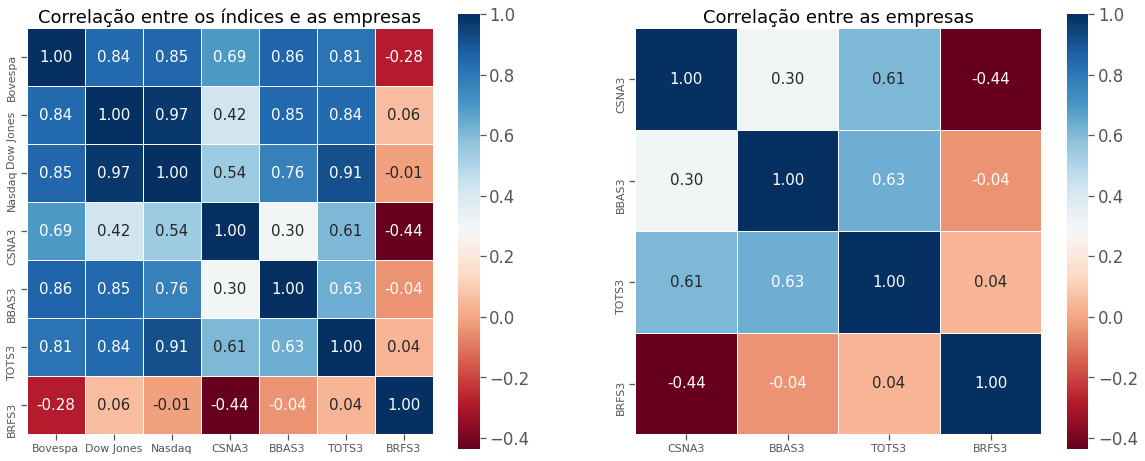

In [83]:
plt.style.use("ggplot")
figs, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) 

sns.set_context('notebook', font_scale= 1.5, rc={'font.size':15, 'axes.titlesize':18, 'axes.labelsize':18})

ax = sns.heatmap(df_retornos.corr(), annot = True, fmt = '.2f', cmap='RdBu', square = True, linewidths=.5, ax = ax1)
ax.set(title = f'Correlação entre os índices e as empresas')

ax = sns.heatmap(df_retornos.drop(columns=['Bovespa', 'Dow Jones', 'Nasdaq']).corr(), annot = True, fmt = '.2f', cmap='RdBu', square = True, linewidths=.5, ax = ax2)
ax.set(title = f'Correlação entre as empresas')

plt.show()

### Retorno e Risco no período

In [84]:
retornos = np.log(df_retornos/df_retornos.shift(1))
retornos = retornos.drop(columns=['Bovespa', 'Dow Jones', 'Nasdaq'])
retorno_risco = pd.DataFrame({'Retorno Diário': np.round(retornos.mean(), 4)})
retorno_risco['% Retorno anualizado'] = np.round((retornos.mean() * 250) * 100, 2)
retorno_risco[' Risco '] = retornos.std()
retorno_risco

Retorno Diário  % Retorno anualizado    Risco 
CSNA3          0.0004                  9.89  0.035697
BBAS3          0.0003                  7.09  0.027763
TOTS3          0.0007                 16.84  0.023190
BRFS3          0.0002                  4.29  0.024134

==================================================================================================================

### Analisando as features para os modelos preditivos

In [89]:
#Inicializar as variáveis com os dados a serem utilizados nos modelos
#obs.: cria um dataframe chamado dataset para facilitar a obtenção dos resultados ativo a ativo
#No caso deste trabalho, são considerados para dados:
#ticker - 'CSNA3', 'BBAS3', 'TOTS3' ou 'BRFS3' que são as ações alvo do estudo
#dataset - recebe os dados de df_csna3, df_bbas3, df_tots3 ou df_brfs3 que foram os datasets gerados anteriormente
ticker = 'TOTS3'
dataset = df_tots3


#dataset = pd.read_csv('Projeto_tcc/base_TOTS3.csv')
#dataset = dataset.rename(columns= {'Unnamed: 0': 'Data'})
#dataset = dataset.reset_index().set_index('Data', drop=True)
#dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d').date
#dataset = dataset.drop(columns='index')

In [90]:
dataset.head()

Bovespa     Dow Jones       Nasdaq  Selic  dolar_Compra  \
2007-01-31  44642.0  12621.690430  2463.929932  12.93        2.1239   
2007-02-01  44815.0  12673.679688  2468.379883  12.93        2.1085   
2007-02-02  44998.0  12653.490234  2475.879883  12.93        2.0974   
2007-02-05  45286.0  12661.740234  2470.600098  12.93        2.0956   
2007-02-06  45352.0  12666.309570  2471.489990  12.93        2.0825   

            dolar_Venda      high       low      open   volume     close  \
2007-01-31       2.1247  3.290414  3.160661  3.160661  1130143  3.253817   
2007-02-01       2.1093  3.327012  3.259806  3.327012   293055  3.273779   
2007-02-02       2.0982  3.260471  3.222543  3.260471   126239  3.246498   
2007-02-05       2.0964  3.307049  3.214559  3.293741   892692  3.227201   
2007-02-06       2.0833  3.247163  3.227201  3.227201  1562964  3.227201   

            adjclose      alvo     mdmv7    mdmv21  
2007-01-31  2.472065  3.273779  3.161612  3.150046  
2007-02-01  2.487232  3.246498  3.182524  3.156383  
2007-02-02  2.466505  3.227201  3.190034  3.155718  
2007-02-05  2.451844  3.227201  3.194787  3.154134  
2007-02-06  2.451844  3.356289  3.211897  3.156035

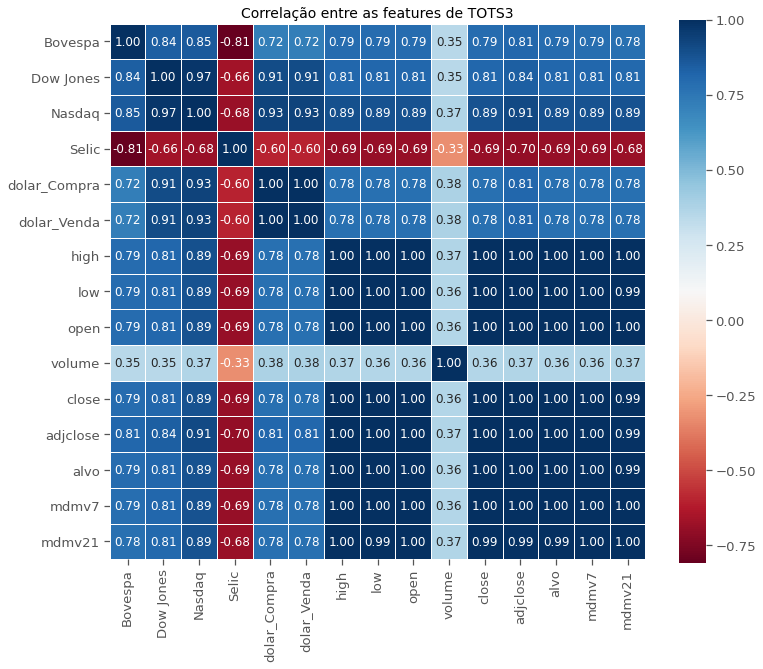

In [91]:
#Plotando o gráfico de correlação entre as features
plt.figure(figsize=(12, 10))
sns.set_context('notebook', font_scale= 1.2, rc={'font.size':12, 'axes.titlesize':14, 'axes.labelsize':15})

ax = sns.heatmap(dataset.corr(), annot = True, fmt = '.2f', cmap='RdBu', square = True, linewidths=.5)
ax.set(title = f'Correlação entre as features de {ticker}')
plt.show()

<Figure size 1440x720 with 0 Axes>

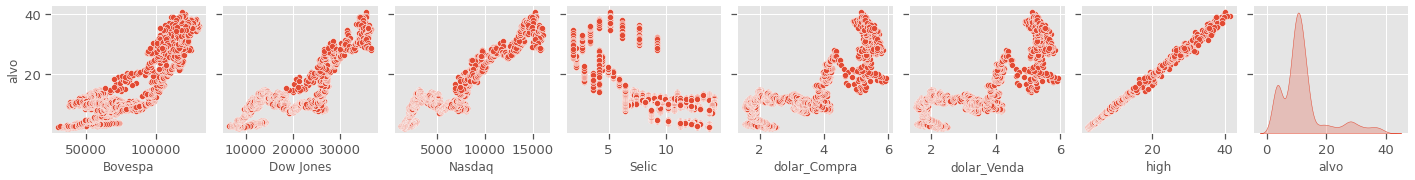

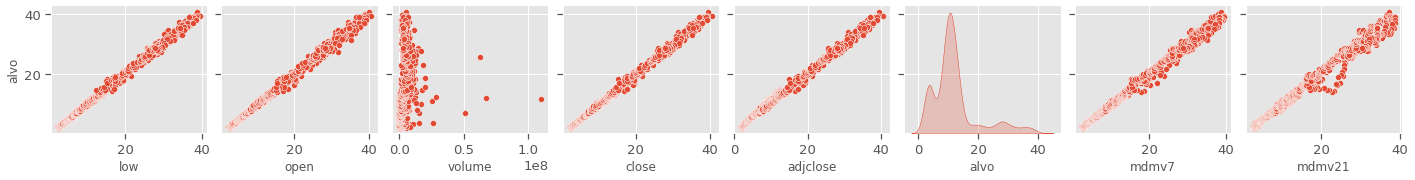

In [92]:
#Plotando gráficos por pares em relação ao alvo
plt.style.use("ggplot")
#figs, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.figure(figsize=(20, 10))

sns.pairplot(dataset.drop(columns=['low', 'open', 'close', 'adjclose', 'mdmv7', 'mdmv21', 'volume']), 
            diag_kind="kde", y_vars=['alvo'])

sns.pairplot(dataset.drop(columns=['Bovespa', 'Dow Jones', 'Nasdaq', 'Selic', 'dolar_Compra', 'dolar_Venda', 'high']), 
             diag_kind="kde", y_vars=['alvo'])
plt.show()

### MODELAGEM

In [93]:
# Carregamento dos dados

#mantém apenas as colunas que não estão 100% correlacionadas ao alvo, 
#e as que agregam informação adicional, como é o caso de 'mdmv7' e 'mdmv21'
features = dataset.drop(columns=['close', 'adjclose', 'alvo', 'open', 'high', 'low'])

#selelciona a coluna alvo, que contem os preços do dia seguinte (objetivo da previsão)
target = dataset.alvo

In [94]:
features.head()

Bovespa     Dow Jones       Nasdaq  Selic  dolar_Compra  \
2007-01-31  44642.0  12621.690430  2463.929932  12.93        2.1239   
2007-02-01  44815.0  12673.679688  2468.379883  12.93        2.1085   
2007-02-02  44998.0  12653.490234  2475.879883  12.93        2.0974   
2007-02-05  45286.0  12661.740234  2470.600098  12.93        2.0956   
2007-02-06  45352.0  12666.309570  2471.489990  12.93        2.0825   

            dolar_Venda   volume     mdmv7    mdmv21  
2007-01-31       2.1247  1130143  3.161612  3.150046  
2007-02-01       2.1093   293055  3.182524  3.156383  
2007-02-02       2.0982   126239  3.190034  3.155718  
2007-02-05       2.0964   892692  3.194787  3.154134  
2007-02-06       2.0833  1562964  3.211897  3.156035

In [96]:
target.shape

(3598,)

In [97]:
#Normalizando os dados das features

scaler = MinMaxScaler().fit(features)
feature_scale = scaler.transform(features)
feature_scale

array([[0.15005773, 0.20288311, 0.08082399, ..., 0.01027493, 0.02207275,
        0.01943797],
       [0.15176483, 0.20461946, 0.08112489, ..., 0.00266437, 0.02263446,
        0.01961269],
       [0.15357062, 0.20394517, 0.08163203, ..., 0.00114773, 0.02283617,
        0.01959435],
       ...,
       [0.75089056, 0.99377955, 0.9874107 , ..., 0.02764697, 0.72430189,
        0.77761855],
       [0.74430882, 0.99698019, 0.98135611, ..., 0.02972624, 0.71655087,
        0.77366668],
       [0.73683899, 1.        , 0.98030802, ..., 0.02913892, 0.70964403,
        0.76808679]])

In [98]:
#Separação dos datasets
#reserva as 60 últimas instâncias para teste de dados futuros, equivalente a 3 meses
X_futuro = feature_scale[ -60: ] #dados de entrada da rede neural para teste futuro
y_futuro = target[-60: ] #alvo de saída da rede neural para teste futuro

#O restante dos dados normalizados são distribuídos nos conjuntos de Treinamento e Teste
X_Dataset = feature_scale[: -60] #dados de entrada da rede neural
y_Dataset = target[: -60] #dados de entrada da rede neural


#Distribuindo porporcionalmente os dados em 80% Treinamento e 20% Teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X_Dataset,
                                                  y_Dataset,
                                                  test_size = 0.20,
                                                  shuffle=False)

In [99]:
print(f"X_treino: {X_treino.shape}, y_treino: {y_treino.shape} \n"
      f"X_teste: {X_teste.shape}, y_teste: {y_teste.shape} \n"
      f"X_futuro: {X_futuro.shape}, y_futuro: {y_futuro.shape} \n")

X_treino: (2830, 9), y_treino: (2830,) 
X_teste: (708, 9), y_teste: (708,) 
X_futuro: (60, 9), y_futuro: (60,) 



In [100]:
y_futuro

2021-09-30    36.770000
2021-10-01    34.869999
2021-10-04    33.799999
2021-10-05    33.349998
2021-10-06    33.369999
2021-10-07    34.660000
2021-10-08    34.080002
2021-10-11    35.740002
2021-10-13    36.220001
2021-10-14    35.290001
2021-10-15    35.799999
2021-10-18    34.389999
2021-10-19    33.459999
2021-10-20    32.560001
2021-10-21    31.879999
2021-10-22    33.380001
2021-10-25    33.400002
2021-10-26    33.200001
2021-10-27    32.910000
2021-10-28    32.759998
2021-10-29    33.099998
2021-11-01    34.320000
2021-11-03    34.450001
2021-11-04    35.000000
2021-11-05    34.500000
2021-11-08    35.110001
2021-11-09    35.099998
2021-11-10    36.360001
2021-11-11    35.560001
2021-11-12    34.770000
2021-11-16    34.509998
2021-11-17    35.360001
2021-11-18    35.320000
2021-11-19    33.099998
2021-11-22    31.450001
2021-11-23    32.119999
2021-11-24    32.389999
2021-11-26    32.139999
2021-11-29    31.690001
2021-11-30    29.809999
2021-12-01    30.270000
2021-12-02    30

======================================================================================

## Modelo Preditivo usando RNN MLPRegression

In [415]:
#Modelagem e Treinamento RNN usando MLPRegression

mlp = MLPRegressor(hidden_layer_sizes = (128, 64, ),
                               activation = 'identity',
                               solver = 'adam',
                               learning_rate = 'adaptive',
                               batch_size = 32, alpha = 0.005,
                               max_iter = 500,
                               random_state = 0)


In [416]:
#Treinamento RNN
mlp.fit(X_treino, y_treino)

MLPRegressor(activation='identity', alpha=0.005, batch_size=32,
             hidden_layer_sizes=(128, 64), learning_rate='adaptive',
             max_iter=500, random_state=0)

In [417]:
#Geração das predições
pred_mlp = mlp.predict(X_teste)

In [418]:
dataset.close[- (X_teste.shape[0] + 60): - 60]

2018-10-23     8.483880
2018-10-24     8.523804
2018-10-25     8.590345
2018-10-26     8.443956
2018-10-29     8.244335
                ...    
2021-09-23    39.130001
2021-09-24    38.000000
2021-09-27    36.869999
2021-09-28    35.599998
2021-09-29    35.480000
Name: close, Length: 708, dtype: float64

In [419]:
#cria dataset para comparação
df_mlp = pd.DataFrame({'real': dataset.close[- (X_teste.shape[0] + 60): - 60], 'previsao': pred_mlp})
df_mlp['Diferenca'] = df_mlp.previsao - df_mlp.real
df_mlp.tail()

real   previsao  Diferenca
2021-09-23  39.130001  38.462887  -0.667114
2021-09-24  38.000000  38.322318   0.322318
2021-09-27  36.869999  38.051045   1.181046
2021-09-28  35.599998  37.729978   2.129979
2021-09-29  35.480000  37.521737   2.041737

In [420]:
#Calculando a precisão do modelo com r2_score
score_p = r2_score(y_teste, pred_mlp)
score_p = np.round(score_p * 100, 2)
score_p

98.56

In [421]:
#Cálculo do erro
mse_mlp = np.round(mean_squared_error(df_mlp.real, df_mlp.previsao), 3)
mae_mlp = np.round(mean_absolute_error(df_mlp.real, df_mlp.previsao), 3)
rmse_mlp = np.round(math.sqrt(mean_squared_error(df_mlp.real, df_mlp.previsao)), 3)
mape_mlp = np.round(mean_absolute_percentage_error(df_mlp.real, df_mlp.previsao) * 100, 3)

print(f' mse = {mse_mlp}\n mae = {mae_mlp}\n rmse = {rmse_mlp}\n mape = {mape_mlp} %')

 mse = 0.687
 mae = 0.592
 rmse = 0.829
 mape = 2.702 %


In [423]:
#Plotando o gráfico do resultado do modelo preditivo para MLPRegression

df_treino = dataset[: X_treino.shape[0]] 
treino = go.Scatter(x = df_treino.index,
                    y = df_treino.close,
                    mode = 'lines',
                    name = 'Dados Treinamento',
                    line = dict(color='green'))

real = go.Scatter(x = df_mlp.index,
                  y = df_mlp.real,
                  mode = 'lines',
                  name = 'Dados Teste',
                  line = dict(color='blue'))

pred = go.Scatter(x = df_mlp.index,
                  y = df_mlp.previsao,
                  mode = 'lines',
                  name = 'Dados Previstos',
                  line = dict(color='orange'))


data = [treino, real, pred]

layout = {
        'title': f'Dados Treinamento X Dados Teste X Dados Previstos / MLPRegression',
        'title_x': 0.5,
        'xaxis': {'title': 'Intervalo de tempo analisado'},
        'yaxis': {'title': f'Preço Fechamento ({ticker})',}
    }
fig = dict(data=data, layout=layout)


py.iplot(fig)

### Teste com dados futuros

In [424]:
#Previsão com dados futuros
previsao_futuro_mlp = mlp.predict(X_futuro)
previsao_futuro_mlp = previsao_futuro_mlp.ravel()

In [425]:
#calcula precisão de predição
score_futuro_mlp = np.round(r2_score(y_futuro, previsao_futuro_mlp) * 100, 2)
score_futuro_mlp

59.64

In [426]:
#Cria dataset para comparação
df_futuro_mlp = pd.DataFrame({'real': dataset.close[- y_futuro.shape[0]: ], 'previsao': previsao_futuro_mlp})
df_futuro_mlp['Diferenca'] = df_futuro_mlp.previsao - df_futuro_mlp.real
df_futuro_mlp.tail()

real   previsao  Diferenca
2021-12-22  29.270000  30.201787   0.931787
2021-12-23  28.740000  29.901055   1.161056
2021-12-27  28.809999  29.485681   0.675682
2021-12-28  28.320000  29.198554   0.878555
2021-12-29  27.889999  28.941512   1.051512

In [427]:
#Lista para armazenar os resultados de teste
#Cálculo do erro
mse_futuro_mlp = np.round(mean_squared_error(df_futuro_mlp.real, df_futuro_mlp.previsao), 3) #erro médio quadrado
mae_futuro_mlp = np.round(mean_absolute_error(df_futuro_mlp.real, df_futuro_mlp.previsao), 3)#erro médio absoluto
rmse_futuro_mlp = np.round(math.sqrt(mean_squared_error(df_futuro_mlp.real, df_futuro_mlp.previsao)), 3) #raiz quadrado do erro médio quadrado
mape_futuro_mlp = np.round(mean_absolute_percentage_error(df_futuro_mlp.real, df_futuro_mlp.previsao) * 100, 3) #Percentual do erro médio absoluto

print(f' mse = {mse_futuro_mlp}\n mae = {mae_futuro_mlp}\n rmse = {rmse_futuro_mlp}\n mape = {mape_futuro_mlp} %')

 mse = 1.48
 mae = 1.001
 rmse = 1.217
 mape = 3.103 %


In [429]:
#Plotando o gráfico do resultado de teste com dados futuros com o modelo preditivo MLPRegression

real = go.Scatter(x = df_futuro_mlp.index,
                  y = df_futuro_mlp.real,
                  mode = 'lines',
                  name = 'Dados Teste Futuro',
                  line = dict(color='blue'))

pred = go.Scatter(x = df_futuro_mlp.index,
                  y = df_futuro_mlp.previsao,
                  mode = 'lines',
                  name = 'Dados Previstos',
                  line = dict(color='orange'))
    
#Obtem somente do dataset original apenas o intervalo de tempo compeendido na previsão
df_candle = dataset[-df_futuro_mlp.shape[0] : ]
    
candle = go.Candlestick(x=df_candle.index,
                           open=df_candle.open,
                           high=df_candle.high,
                           low=df_candle.low,
                           close=df_candle.close,
                           name = 'Candlestick')

data = [real, pred, candle]

layout = {
    'title': 'Dados Futuros X Dados Preditos - Período 10/2021 a 12/2021',
    'title_x': 0.5,
    'xaxis': {'title': 'Intervalo de tempo analisado'},
    'yaxis': {'title': f'Preço Fechamento ({ticker})',}
    }
fig = dict(data=data, layout=layout)


py.iplot(fig)

=======================================================================================

### Modelagem e Treinamento de Rede Neural Recorrente RNN usando LSTM

In [592]:

#Remodelando os dados de treinos e testes para o formato 3D para redes LSTM
#x_treino_lstm.shape[0] = batch_size (2693)- tamanho do dataset de treinamento
#x_treino_lstm.shape[1] = num_step (60) - número de etapas anteriores
#x_treino_lstm.shape[2] = input_dim (9) - número de features

X1, X2, y1, y2 = list(), list(), list(), list()
num_steps = 60
# remodelando os dados de treino
for i in range(num_steps, X_treino.shape[0]):
    X1.append(X_treino[i-num_steps: i])
    y1.append(y_treino[i])
x_treino_lstm = np.array(X1)
y_treino_lstm = np.array(y1)

#verifica se o tamanho de y_treino_lstm é igual ao de x_treino_lstm
assert x_treino_lstm.shape[0] == y_treino_lstm.shape[0]

print(f'Dataset de treinamento X: {x_treino_lstm.shape} e y: {y_treino_lstm.shape}')

# remodelando os dados de teste considerando os num_steps
teste_x = feature_scale[- y_teste.shape[0] - num_steps - 60: -60]
teste_y = target[- y_teste.shape[0] - num_steps - 60: -60]

for i in range(num_steps, teste_x.shape[0]):
    X2.append(teste_x[i-num_steps: i])
    y2.append(teste_y[i])
x_teste_lstm = np.array(X2)
y_teste_lstm = np.array(y2)

#verifica se o tamanho de y_teste_lsmt é igual ao de x_teste_lstm
assert x_teste_lstm.shape[0] == y_teste_lstm.shape[0]

print(f'Dataset de teste X: {x_teste_lstm.shape} e y {y_teste_lstm.shape}')
    

Dataset de treinamento X: (2770, 60, 9) e y: (2770,)
Dataset de teste X: (708, 60, 9) e y (708,)


In [191]:
from keras import backend

In [594]:
#Criação da LSTM utilizando a biblioteca Keras

#Criando uma RNN LSTM
rn_lstm = Sequential()

# Adiciona a primeira camada LSTM com 128 neurônios com o Dropout
#O parâmetro input_shape = recebe nº de etapas anteriores e nº de features de entrada
    
rn_lstm.add(LSTM(units = 128, activation = 'tanh',kernel_initializer = 'normal',
                input_shape = (x_treino_lstm.shape[1],
                               x_treino_lstm.shape[2]),
                return_sequences = False))
#Adiciona uma camada Dropout para evitar o Overfitting
rn_lstm.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com 64 neorônios
#rn_lstm.add(LSTM(units = 64))
#rn_lstm.add(Dropout(0.3))

# Adiciona a última camada, 1 neurônio de saída
rn_lstm.add(Dense(units = 1, activation = 'linear'))

# Compila a RNN, neste caso utilizando o otimizador
rn_lstm.compile(optimizer = 'adam', loss = 'mse', metrics=['mae'])


In [595]:
#Treinando modelo LSTM
backend.clear_session()
epocas = 500
historico = rn_lstm.fit(x_treino_lstm, y_treino_lstm, 
                        epochs = epocas, batch_size = 32,
                        validation_data = (x_teste_lstm, y_teste_lstm))
rn_lstm.summary()

Epoch 1/500
87/87 [==============================] - 12s 103ms/step - loss: 39.3580 - mae: 5.0421 - val_loss: 251.7308 - val_mae: 13.5281
Epoch 2/500
87/87 [==============================] - 9s 98ms/step - loss: 10.8309 - mae: 2.6771 - val_loss: 253.1269 - val_mae: 13.6404
Epoch 3/500
87/87 [==============================] - 9s 108ms/step - loss: 10.5745 - mae: 2.6722 - val_loss: 226.3971 - val_mae: 12.7863
Epoch 4/500
87/87 [==============================] - 9s 106ms/step - loss: 9.6346 - mae: 2.5478 - val_loss: 202.0082 - val_mae: 11.9592
Epoch 5/500
87/87 [==============================] - 10s 110ms/step - loss: 8.1625 - mae: 2.3607 - val_loss: 194.1474 - val_mae: 11.6614
Epoch 6/500
87/87 [==============================] - 9s 98ms/step - loss: 8.2460 - mae: 2.3287 - val_loss: 156.3356 - val_mae: 10.3158
Epoch 7/500
87/87 [==============================] - 11s 132ms/step - loss: 2.8007 - mae: 1.3461 - val_loss: 162.5354 - val_mae: 10.4835
Epoch 8/500
87/87 [=========================

87/87 [==============================] - 4s 50ms/step - loss: 0.5289 - mae: 0.5544 - val_loss: 62.2853 - val_mae: 6.4369
Epoch 62/500
87/87 [==============================] - 4s 48ms/step - loss: 0.5107 - mae: 0.5571 - val_loss: 57.5991 - val_mae: 6.0448
Epoch 63/500
87/87 [==============================] - 4s 48ms/step - loss: 0.4950 - mae: 0.5406 - val_loss: 56.3613 - val_mae: 5.9694
Epoch 64/500
87/87 [==============================] - 4s 47ms/step - loss: 0.5148 - mae: 0.5585 - val_loss: 60.7972 - val_mae: 6.4295
Epoch 65/500
87/87 [==============================] - 4s 49ms/step - loss: 0.5855 - mae: 0.5792 - val_loss: 49.1787 - val_mae: 5.5062
Epoch 66/500
87/87 [==============================] - 5s 53ms/step - loss: 0.5090 - mae: 0.5523 - val_loss: 51.1464 - val_mae: 5.7895
Epoch 67/500
87/87 [==============================] - 5s 55ms/step - loss: 0.4889 - mae: 0.5432 - val_loss: 45.3980 - val_mae: 5.2028
Epoch 68/500
87/87 [==============================] - 4s 52ms/step - loss: 

87/87 [==============================] - 4s 46ms/step - loss: 0.4178 - mae: 0.4969 - val_loss: 24.9037 - val_mae: 3.9296
Epoch 123/500
87/87 [==============================] - 4s 47ms/step - loss: 0.4414 - mae: 0.5169 - val_loss: 21.2864 - val_mae: 3.4593
Epoch 124/500
87/87 [==============================] - 4s 47ms/step - loss: 0.4400 - mae: 0.5088 - val_loss: 29.8228 - val_mae: 4.4211
Epoch 125/500
87/87 [==============================] - 4s 48ms/step - loss: 0.4517 - mae: 0.5133 - val_loss: 26.9960 - val_mae: 4.2019
Epoch 126/500
87/87 [==============================] - 5s 52ms/step - loss: 0.4211 - mae: 0.4925 - val_loss: 23.6424 - val_mae: 3.8764
Epoch 127/500
87/87 [==============================] - 4s 51ms/step - loss: 0.4298 - mae: 0.5027 - val_loss: 19.6280 - val_mae: 3.3561
Epoch 128/500
87/87 [==============================] - 4s 48ms/step - loss: 0.4640 - mae: 0.5145 - val_loss: 21.5691 - val_mae: 3.6759
Epoch 129/500
87/87 [==============================] - 5s 58ms/step -

Epoch 183/500
87/87 [==============================] - 4s 47ms/step - loss: 0.3683 - mae: 0.4648 - val_loss: 12.9589 - val_mae: 2.8348
Epoch 184/500
87/87 [==============================] - 4s 46ms/step - loss: 0.4122 - mae: 0.4903 - val_loss: 13.0861 - val_mae: 2.8530
Epoch 185/500
87/87 [==============================] - 4s 47ms/step - loss: 0.4086 - mae: 0.4886 - val_loss: 13.9745 - val_mae: 2.9953
Epoch 186/500
87/87 [==============================] - 4s 47ms/step - loss: 0.3736 - mae: 0.4697 - val_loss: 11.5517 - val_mae: 2.5863
Epoch 187/500
87/87 [==============================] - 4s 47ms/step - loss: 0.3815 - mae: 0.4711 - val_loss: 10.6955 - val_mae: 2.4372
Epoch 188/500
87/87 [==============================] - 4s 47ms/step - loss: 0.3658 - mae: 0.4578 - val_loss: 10.0039 - val_mae: 2.3339
Epoch 189/500
87/87 [==============================] - 5s 52ms/step - loss: 0.3802 - mae: 0.4691 - val_loss: 8.9507 - val_mae: 2.1215
Epoch 190/500
87/87 [==============================] - 4

87/87 [==============================] - 4s 46ms/step - loss: 0.3229 - mae: 0.4249 - val_loss: 5.1775 - val_mae: 1.7195
Epoch 245/500
87/87 [==============================] - 4s 46ms/step - loss: 0.3231 - mae: 0.4301 - val_loss: 5.1377 - val_mae: 1.7357
Epoch 246/500
87/87 [==============================] - 4s 46ms/step - loss: 0.2951 - mae: 0.4103 - val_loss: 5.6898 - val_mae: 1.8600
Epoch 247/500
87/87 [==============================] - 4s 50ms/step - loss: 0.3150 - mae: 0.4235 - val_loss: 6.3741 - val_mae: 1.9976
Epoch 248/500
87/87 [==============================] - 4s 46ms/step - loss: 0.3155 - mae: 0.4263 - val_loss: 5.4163 - val_mae: 1.7103
Epoch 249/500
87/87 [==============================] - 4s 46ms/step - loss: 0.3293 - mae: 0.4272 - val_loss: 5.1904 - val_mae: 1.7198
Epoch 250/500
87/87 [==============================] - 4s 49ms/step - loss: 0.2847 - mae: 0.4002 - val_loss: 5.7494 - val_mae: 1.9140
Epoch 251/500
87/87 [==============================] - 4s 46ms/step - loss: 

87/87 [==============================] - 4s 47ms/step - loss: 0.2956 - mae: 0.4058 - val_loss: 3.9761 - val_mae: 1.5907
Epoch 306/500
87/87 [==============================] - 4s 51ms/step - loss: 0.2722 - mae: 0.3941 - val_loss: 3.9242 - val_mae: 1.6218
Epoch 307/500
87/87 [==============================] - 4s 49ms/step - loss: 0.2953 - mae: 0.4050 - val_loss: 3.6508 - val_mae: 1.5187
Epoch 308/500
87/87 [==============================] - 4s 47ms/step - loss: 0.2888 - mae: 0.4064 - val_loss: 3.2692 - val_mae: 1.4314
Epoch 309/500
87/87 [==============================] - 4s 46ms/step - loss: 0.2458 - mae: 0.3711 - val_loss: 4.7433 - val_mae: 1.8338
Epoch 310/500
87/87 [==============================] - 4s 47ms/step - loss: 0.2833 - mae: 0.4003 - val_loss: 3.8966 - val_mae: 1.6128
Epoch 311/500
87/87 [==============================] - 4s 49ms/step - loss: 0.2717 - mae: 0.3916 - val_loss: 3.3506 - val_mae: 1.3501
Epoch 312/500
87/87 [==============================] - 4s 48ms/step - loss: 

87/87 [==============================] - 4s 48ms/step - loss: 0.2462 - mae: 0.3713 - val_loss: 2.4000 - val_mae: 1.1821
Epoch 367/500
87/87 [==============================] - 5s 61ms/step - loss: 0.2308 - mae: 0.3607 - val_loss: 3.7209 - val_mae: 1.5980
Epoch 368/500
87/87 [==============================] - 5s 56ms/step - loss: 0.2291 - mae: 0.3615 - val_loss: 2.0837 - val_mae: 1.0921
Epoch 369/500
87/87 [==============================] - 5s 53ms/step - loss: 0.2775 - mae: 0.3848 - val_loss: 2.4475 - val_mae: 1.2308
Epoch 370/500
87/87 [==============================] - 5s 53ms/step - loss: 0.2293 - mae: 0.3605 - val_loss: 4.4017 - val_mae: 1.4145
Epoch 371/500
87/87 [==============================] - 4s 47ms/step - loss: 0.2733 - mae: 0.3910 - val_loss: 2.6605 - val_mae: 1.1906
Epoch 372/500
87/87 [==============================] - 4s 47ms/step - loss: 0.2367 - mae: 0.3670 - val_loss: 2.8998 - val_mae: 1.2446
Epoch 373/500
87/87 [==============================] - 4s 49ms/step - loss: 

87/87 [==============================] - 4s 48ms/step - loss: 0.2068 - mae: 0.3380 - val_loss: 2.9129 - val_mae: 1.1778
Epoch 428/500
87/87 [==============================] - 4s 45ms/step - loss: 0.2003 - mae: 0.3369 - val_loss: 2.4808 - val_mae: 1.1286
Epoch 429/500
87/87 [==============================] - 4s 46ms/step - loss: 0.1956 - mae: 0.3349 - val_loss: 2.5929 - val_mae: 1.1871
Epoch 430/500
87/87 [==============================] - 4s 46ms/step - loss: 0.2056 - mae: 0.3378 - val_loss: 2.2304 - val_mae: 1.1327
Epoch 431/500
87/87 [==============================] - 4s 46ms/step - loss: 0.1978 - mae: 0.3334 - val_loss: 2.1326 - val_mae: 1.1161
Epoch 432/500
87/87 [==============================] - 4s 46ms/step - loss: 0.2042 - mae: 0.3361 - val_loss: 2.4679 - val_mae: 1.1295
Epoch 433/500
87/87 [==============================] - 4s 46ms/step - loss: 0.2045 - mae: 0.3361 - val_loss: 2.8290 - val_mae: 1.1665
Epoch 434/500
87/87 [==============================] - 4s 45ms/step - loss: 

87/87 [==============================] - 4s 46ms/step - loss: 0.1758 - mae: 0.3134 - val_loss: 6.6927 - val_mae: 2.2385
Epoch 489/500
87/87 [==============================] - 4s 46ms/step - loss: 0.1790 - mae: 0.3165 - val_loss: 4.7184 - val_mae: 1.8207
Epoch 490/500
87/87 [==============================] - 5s 55ms/step - loss: 0.1815 - mae: 0.3240 - val_loss: 4.1660 - val_mae: 1.7082
Epoch 491/500
87/87 [==============================] - 4s 45ms/step - loss: 0.1743 - mae: 0.3196 - val_loss: 5.1496 - val_mae: 1.9357
Epoch 492/500
87/87 [==============================] - 4s 46ms/step - loss: 0.1845 - mae: 0.3237 - val_loss: 2.9809 - val_mae: 1.4148
Epoch 493/500
87/87 [==============================] - 4s 51ms/step - loss: 0.1778 - mae: 0.3194 - val_loss: 4.1935 - val_mae: 1.7149
Epoch 494/500
87/87 [==============================] - 4s 48ms/step - loss: 0.1744 - mae: 0.3150 - val_loss: 4.0228 - val_mae: 1.6671
Epoch 495/500
87/87 [==============================] - 5s 54ms/step - loss: 

Text(0.5, 1.0, 'Histórico de aprendizagem  epocas 500 TOTS3')

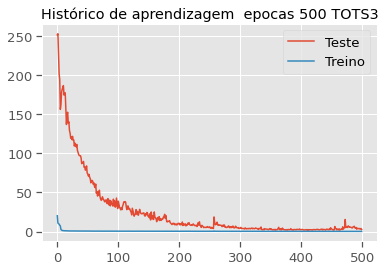

In [618]:
#plotando as camadas do modelo LSTM
plot_model(rn_lstm, show_shapes=True, to_file = f'/home/yuko/Projeto_tcc/TOTS3/Gráficos de Resultado/resultados LSTM/Adam/1 camada LSTM/Modelo TOTS3 LSTM 128 - tanh-adam-ep-500.h5.png')
rn_lstm.save(f'Projeto_tcc/modelos TOTS3/{ticker} {epocas}.h5')

#Plotando histórico de perda do modelo baseado na métrica MSE
#plt.figure(figsize=(10,5))
historico.history.keys()
plt.plot(historico.history['val_loss'], label = f'Teste')
plt.plot(historico.history['loss'], label = f'Treino')
plt.legend()
plt.title(f'Histórico de aprendizagem  epocas {epocas} {ticker}')


In [602]:
from keras.models import load_model

In [603]:
# Carregar modelo de arquivo
#rn_lstm = load_model(f'Projeto_tcc/modelos TOTS3/{ticker} {epocas}.h5')
#Testando a previsão do modelo
pred_lstm = rn_lstm.predict(x_teste_lstm)
#previsao = pred_lstm.reshape(-1, 1)
pred_lstm = pred_lstm.ravel()

In [604]:
pred_lstm.shape

(708,)

In [605]:
#cria dataset para avaliação e comparações
df_lstm = pd.DataFrame({'real': dataset.close[(- y_teste_lstm.shape[0] - 60) : - 60], 
                        'previsao': pred_lstm})
df_lstm['Diferenca'] = df_lstm.previsao - df_lstm.real

df_lstm.tail()

real   previsao  Diferenca
2021-09-23  39.130001  38.347473  -0.782528
2021-09-24  38.000000  38.294510   0.294510
2021-09-27  36.869999  38.282066   1.412067
2021-09-28  35.599998  38.195160   2.595161
2021-09-29  35.480000  38.004845   2.524845

In [606]:
#Calculando a precisão do modelo
score_lstm = r2_score(y_teste_lstm, pred_lstm)
score_p = np.round(score_lstm * 100, 2)
score_p

96.38

In [608]:
#Cálculo do erro
mse_lstm = np.round(mean_squared_error(df_lstm.real, df_lstm.previsao), 3)
mae_lstm = np.round(mean_absolute_error(df_lstm.real, df_lstm.previsao), 3)
rmse_lstm = np.round(math.sqrt(mean_squared_error(df_lstm.real, df_lstm.previsao)), 3)
mape_lstm = np.round(mean_absolute_percentage_error(df_lstm.real, df_lstm.previsao) * 100, 3)

print(f' mse = {mse_lstm}\n mae = {mae_lstm}\n rmse = {rmse_lstm}\n mape = {mape_lstm}')

 mse = 2.217
 mae = 1.2
 rmse = 1.489
 mape = 5.68


In [609]:
#Plotando o gráfico do resultado do modelo preditivo para MLPRegression

df_treino = dataset[: X_treino.shape[0]] 
treino = go.Scatter(x = df_treino.index,
                    y = df_treino.close,
                    mode = 'lines',
                    name = 'Dados Treinamento',
                    line = dict(color='green'))

real = go.Scatter(x = df_lstm.index,
                  y = df_lstm.real,
                  mode = 'lines',
                  name = 'Dados Teste',
                  line = dict(color='blue'))

pred = go.Scatter(x = df_lstm.index,
                  y = df_lstm.previsao,
                  mode = 'lines',
                  name = 'Dados Previstos',
                  line = dict(color='orange'))


data = [treino, real, pred]

layout = {
        'title': f'Dados Treinamento X Dados Teste X Dados Previstos / LSTM',
        'title_x': 0.5,
        'xaxis': {'title': 'Intervalo de tempo analisado'},
        'yaxis': {'title': f'Preço Fechamento ({ticker})',}
    }
fig = dict(data=data, layout=layout)


py.iplot(fig)

### Testando os modelos com dados novos (X_futuro, y_futuro)

In [610]:
# remodelando os dados (X_futuro, y_futuro) considerando os num_steps
num_steps = 60
x, y = list(), list()

futuro_x = feature_scale[- (y_futuro.shape[0] + num_steps) :]
futuro_y = target[- (y_futuro.shape[0] + num_steps) :]

for i in range(num_steps, futuro_x.shape[0]):
    x.append(futuro_x[i-num_steps: i])
    y.append(futuro_y[i])
    x_futuro_lstm = np.array(x)
    y_futuro_lstm = np.array(y)

    #verifica se o tamanho de y_futuro_lsmt é igual ao de x_futuro_lstm
    assert x_futuro_lstm.shape[0] == y_futuro_lstm.shape[0]

In [611]:
#Previsão com dados futuros
previsao_futuro_lstm = rn_lstm.predict(x_futuro_lstm)
previsao_futuro_lstm = previsao_futuro_lstm.ravel()

In [612]:
previsao_futuro_lstm.shape

(60,)

In [613]:
#calcula precisão de predição
score_futuro_lstm = np.round(r2_score(y_futuro_lstm, previsao_futuro_lstm) * 100, 2)
score_futuro_lstm

-45.59

In [615]:
#Cria dataset para comparação
df_futuro_lstm = pd.DataFrame({'real': dataset.close[- y_futuro.shape[0]: ], 'previsao': previsao_futuro_lstm})
df_futuro_lstm['Diferenca'] = df_futuro_lstm.previsao - df_futuro_lstm.real
df_futuro_lstm.tail()

real   previsao  Diferenca
2021-12-22  29.270000  30.229622   0.959621
2021-12-23  28.740000  29.971262   1.231262
2021-12-27  28.809999  29.720095   0.910095
2021-12-28  28.320000  29.490030   1.170031
2021-12-29  27.889999  29.256462   1.366463

In [616]:
#Lista para armazenar os resultados de teste
#Cálculo do erro
mse_futuro_lstm = np.round(mean_squared_error(df_futuro_lstm.real, df_futuro_lstm.previsao), 3) #erro médio quadrado
mae_futuro_lstm = np.round(mean_absolute_error(df_futuro_lstm.real, df_futuro_lstm.previsao), 3)#erro médio absoluto
rmse_futuro_lstm = np.round(math.sqrt(mean_squared_error(df_futuro_lstm.real, df_futuro_lstm.previsao)), 3) #raiz quadrado do erro médio quadrado
mape_futuro_lstm = np.round(mean_absolute_percentage_error(df_futuro_lstm.real, df_futuro_lstm.previsao) * 100, 3) #Percentual do erro médio absoluto

print(f' mse = {mse_futuro_lstm}\n mae = {mae_futuro_lstm}\n rmse = {rmse_futuro_lstm}\n mape = {mape_futuro_lstm}%')

 mse = 7.034
 mae = 2.336
 rmse = 2.652
 mape = 7.25%


In [617]:
#Plotando o gráfico do resultado de teste com dados futuros com o modelo preditivo MLPRegression

real = go.Scatter(x = df_futuro_lstm.index,
                  y = df_futuro_lstm.real,
                  mode = 'lines',
                  name = 'Dados Teste Futuro',
                  line = dict(color='blue'))

pred = go.Scatter(x = df_futuro_lstm.index,
                  y = df_futuro_lstm.previsao,
                  mode = 'lines',
                  name = 'Dados Previstos',
                  line = dict(color='orange'))
    
#Obtem somente do dataset original apenas o intervalo de tempo compeendido na previsão
df_candle = dataset[-df_futuro_lstm.shape[0] : ]
    
candle = go.Candlestick(x=df_candle.index,
                           open=df_candle.open,
                           high=df_candle.high,
                           low=df_candle.low,
                           close=df_candle.close,
                           name = 'Candlestick')

data = [real, pred, candle]

layout = {
    'title': 'Dados Futuros X Dados Preditos - Período 10/2021 a 12/2021',
    'title_x': 0.5,
    'xaxis': {'title': 'Intervalo de tempo analisado'},
    'yaxis': {'title': f'Preço Fechamento ({ticker})',}
    }
fig = dict(data=data, layout=layout)


py.iplot(fig)